This notebook is to test the efficiency of cell-list data structure to guess bonds between atoms along with comparison with present implementation of distances array for guessing bonds. The function is modified using a helper function to compare different size of datasets. Finally, the time reduction for uessing of bonds is shown using the test universe available in MDAnalysis.Tests.

In [1]:
import numpy as np
from MDAnalysis.lib.distances import distance_array
import cellgrid
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import itertools

In [2]:
import importlib
importlib.reload(cellgrid)

<module 'cellgrid' from '/home/karan/miniconda3/envs/mda/lib/python3.6/site-packages/cellgrid-0.1.0-py3.6-linux-x86_64.egg/cellgrid/__init__.py'>

In [3]:
def bf_guessbond( points, atoms = None,  box = None):
    """
    Guess the bonds of particles
    Two atoms form bonds if d < f*(R1 + R2)
    """
    if atoms is None:
        ### Use default values
        vdw = 2.0
        atoms = np.ones(len(points), dtype = np.float32)*vdw
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atoms):
            print("Atoms and Coordinates should have equal length")
            return
        ####Every atom corresponds to a radius for its respective particle
        
    fudge_factor = 0.72
    lower_bound = 0.1

    
    bonds = []
    # Define a maximum distance for every atom to search based on the radius 
    # of the atom and maximum radius of atom in the atom list.
    max_vdw = np.amax(atoms) 
    
    # Self distance use very high amount of memory for large particles
    # Individual particles should be used instead of sparse matrix 
    # for all the pairs
    for i,coordinate in enumerate(points):
        vdw_i = atoms[i]
        max_d = (vdw_i + max_vdw) * fudge_factor
        dist = distance_array(points[i][None, :], points[i + 1:],box=box)[0]
        idx = np.where((dist > lower_bound) & (dist <= max_d))[0]
        for a in idx:
            j = i + 1 + a
            atom_j = points[j]
            if dist[a] < (atoms[j] + vdw_i)*fudge_factor:
                bonds.append((i, j))
    return tuple(bonds)

In [4]:
def cg_guessbonds(points, atoms = None, box = None):
    """
    Guessing Bonds with cell-List data structures 
    as implemented in Cellgrid Structure
    """ 
    if atoms is None:
        ### Use default values
        vdw = 2.0
        atoms = np.ones(len(points), dtype = np.float32)*vdw
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atoms):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1
    
    bonds = []

    max_vdw = np.amax(atoms)
    
    indx,dist = cellgrid.capped_self_distance_array(points, 2.0*max_vdw*fudge_factor, box=box[:3])
    mask = np.where((dist <= (2.0*max_vdw)*fudge_factor) & (dist > lower_bound))
    for num, (i,j) in enumerate(indx[mask]):
        if dist[mask][num] < (atoms[i] + atoms[j]) * fudge_factor:
            bonds.append((i,j))  
    return tuple(bonds)

In [5]:
def kd_guessbonds(points, atoms = None, box = None):
    """
    Already implemented tree structure in MDAnalysis
    """
    if atoms is None:
        ### Use default values
        vdw = 2.0
        atoms = np.ones(len(points), dtype = np.float32)*vdw
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atoms):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    
    max_vdw = np.amax(atoms)
    
    kdtree = PeriodicKDTree(box, bucket_size=10)
    kdtree.set_coords(points)
    
    for idx,centers in enumerate(points):
        vdw_i = atoms[idx]
        max_d = (vdw_i + max_vdw)*fudge_factor
        kdtree.search(centers,max_d)
        indices = kdtree.get_indices()
        dist = distance_array(centers.reshape((1,3)), points[indices],box=box)[0]
        index = np.where((dist > lower_bound) & (dist <= max_d))[0]
        for j in index:
            if (indices[j] > idx) and (dist[j] < (atoms[indices[j]] + vdw_i)*fudge_factor):
                bonds.append((idx, indices[j])) 
    return tuple(bonds)

In [11]:
# Neighbour search FATSLiM
from core_ns import FastNS
def ns_guessbonds(points, atoms = None, box = None):
    if atoms is None:
        ### Use default values
        vdw = 2.0
        atoms = np.ones(len(points), dtype = np.float32)*vdw
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atoms):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    
    max_vdw = np.amax(atoms)
    
    triclinic_box = np.array([[box[0], 0, 0],[0, box[1], 0],[0,0,box[2]]], dtype=np.float32)
    searcher = FastNS(triclinic_box)
    searcher.set_cutoff(2*max_vdw)
    searcher.set_coords(points)
    searcher.prepare()
    for idx, centers in enumerate(points):
        vdw_i = atoms[idx]
        max_d = (vdw_i + max_vdw)*fudge_factor
        
        results, sqdist, index = searcher.search(np.array([centers,]))
        if len(index[0]) > 0:
            for i, val in enumerate(index[0]):
                d = (atoms[val] + vdw_i)*fudge_factor
                if (sqdist[0][i] < d*d) and (val > idx):
                    bonds.append((idx, val))
    return bonds

For a single type of atom, lets check the time to guess bonds

In [6]:
#Initialization
BOX = np.array([100., 100., 100., 90., 90., 90.], dtype = np.float32)
NPOINTS = 100000

In [7]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [8]:
points = get_coords(BOX, NPOINTS)

In [ ]:
bonds = bf_guessbond(points, box = BOX)

In [ ]:
cgbonds = cg_guessbonds(points, box = BOX[:3])
len(cgbonds)

In [ ]:
kdbonds = kd_guessbonds(np.array(points, dtype = np.float32), box = BOX)
print(len(kdbonds))

In [ ]:
nsbonds = ns_guessbonds(points, box = BOX)
print(len(nsbonds))

In [ ]:
time_bf = %timeit -q -o -n 1 -r 1 bf_guessbond(points, box = BOX)

In [ ]:
time_cg = %timeit -q -o -n 1 -r 1 cg_guessbonds(points, box = BOX[:3])

In [ ]:
time_kd = %timeit -q -o -n 1 -r 1 kd_guessbonds(points, box = BOX)

In [ ]:
time_ns = %timeit -q -o -n 1 -r 1 ns_guessbonds(points, box = BOX)

In [ ]:
time_bf.average, time_cg.average, time_kd.average, time_ns.average

Cell Grid performs better for 1000 particles. Lets check the variation of time for guessing bonds with number of particles, provided a constant bond length i.e all particles are similar.

In [9]:
#Initial Setup
NPOINTS = np.logspace(2, 5, num = 10, dtype = np.int32)
BOX = np.array([100., 100., 100., 90., 90., 90.], dtype = np.float32)

In [13]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(np.logspace(2, 5, num = 10, dtype = np.int32))):
    points = get_coords(BOX, N)
    
    #KDTree
    res = %timeit -o -q -n 5 -r 5 kd_guessbonds(points, box = BOX)
    result['pkdt'].append(res.average)
    
    #Brute Force
    res = %timeit -o -q -n 5 -r 5 bf_guessbond(points, box = BOX)
    result['bf'].append(res.average)
    
    #CG
    #res = %timeit -o -q -n 5 -r 5 cg_guessbonds(points, box = BOX[:3])
    #result['cg'].append(res.average)
    
    #NS
    res = %timeit -o -q -n 5 -r 5 ns_guessbonds(points, box = BOX)
    result['ns'].append(res.average)
    
    result['N'].append(N)



In [15]:
%matplotlib inline

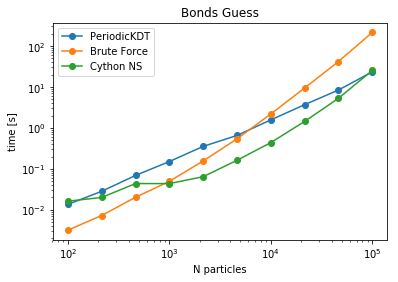

In [17]:
import matplotlib
import matplotlib.pyplot as plt
fig, axes = plt.subplots()

axes.plot(result['N'], result['pkdt'], 'o-', label='PeriodicKDT')
axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
#axes.plot(result['N'], result['cg'], 'o-', label='Cell Grid')
axes.plot(result['N'], result['ns'], 'o-', label='Cython NS')
axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Bonds Guess')
axes.legend()

Suppose every particle has a certain vanderwall radius. The objective is now to distribute a vaue of random radius to each particle and check the timing with different number of particles. 

First define an helper function to distribute atomtypes corresponding 

In [18]:
import MDAnalysis.topology.tables as tables
def define_atoms(N):
    atomtype = ['C', 'H']
    atomtypes = np.random.choice(atomtype, size = N)
    vdwradii = tables.vdwradii.copy()
    atoms = [vdwradii[i] for i in atomtypes]
    return atoms

In [19]:
NPOINTS = np.logspace(2, 5, num = 10, dtype = np.int32)
BOX = np.array([100., 100., 100., 90., 90., 90.], dtype = np.float32)

In [ ]:
from tqdm import tqdm_notebook
from collections import defaultdict

time2 = defaultdict(list)
for N in tqdm_notebook(np.unique(NPOINTS)):
    points = get_coords(BOX, N)
    atoms = define_atoms(N)
    

    #Brute Force
    time_bf = %timeit -q -o -n 5 -r 5 bf_guessbond(points, atoms = atoms,  box = BOX)
    time2['bf'].append(time_bf.average)
    
    #Cellgrid
    #time_cg = %timeit -q -o -n 5 -r 5 cg_guessbonds(points, atoms = atoms,  box = BOX[:3])
    #time2['cg'].append(time_cg.average)
    
    #KDTree
    time_kd = %timeit -q -o -n 5 -r 5 kd_guessbonds(points, atoms = atoms,  box = BOX)
    time2['kd'].append(time_kd.average)
    
    #NS
    res = %timeit -o -q -n 5 -r 5 ns_guessbonds(points, atoms = atoms,  box = BOX)
    result['ns'].append(res.average)

    time2['N'].append(N)

In [ ]:
fig, axes = plt.subplots()

axes.plot(time2['N'], time['pkdt'], 'o-', label='PeriodicKDT')
axes.plot(time2['N'], time['bf'], 'o-', label='Brute Force')
axes.plot(time2['N'], time['cg'], 'o-', label='Cell Grid')
#axes.plot(time2['N'], time['ns'], 'o-', label='Cython NS')
axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Bonds Guess')
axes.legend()